# How does healthcare funding impact tuberculosis outcomes across different countries?

TB is seen as one of top deadliest diseases that highly affects people with HIV/AIDS 

In [75]:
### importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Load, Data clean and transform

In [3]:
#load dataset
tb = pd.read_csv("tb incident.csv", usecols = [0,2,3] ,low_memory = True) #138 obs and 3 cols
tb_death = pd.read_csv("tb_death_rate.csv", usecols = [0,1,2,3],low_memory = True) #195 obs and 5 cols
tb_funding = pd.read_csv("tb_funding.csv",usecols = [0,1,2,3,5,6,7,8,9,10],low_memory = True,float_precision='round_trip')
pd.options.display.float_format = '{:.4f}'.format #to help break scientific values 

In [4]:
#renaming columns in the dataset
tb = tb.rename({'Estimated incidence of all forms of tuberculosis': 'est_incidence'}, axis='columns')
tb_death = tb_death.rename({'Estimated mortality from all forms of tuberculosis per 100,000 population': 'est_mortality'}, axis='columns')
tb_funding = tb_funding.rename({'Expected funding from the Global Fund to Fight AIDS, Tuberculosis and Malaria': 'exp_global_fund'}, axis='columns')
tb.columns

Index(['Entity', 'Year', 'est_incidence'], dtype='object')

from the 'tb' dataset -  renamed Estimated incidence of all forms of tuberculosis to est_incidence
from the 'tb_death' dataset - Estimated mortality from all forms of tuberculosis per 100,000 population to est_mortality
from the 'tb_funding' dataset - Expected funding from the Global Fund to Fight AIDS, Tuberculosis and Malaria to exp_global_fund


In [5]:
## unpivot tb_funding dataset to change the shape of the data
tb_funding_1= tb_funding.melt(id_vars=["Entity","Code","exp_global_fund","Attribute"], var_name="funding_year", value_name='value')

In [6]:
tb_funding_1.dropna(subset=['value'], inplace=True) ## dropped all the NAN's from the value column in the funding dataset

In [7]:
tb_funding_1['Group_Index'] = tb_funding_1.groupby('Attribute').cumcount() + 1 #created an index column to aid pivoting the funding dataset 
pivoted = tb_funding_1.pivot(index='Group_Index', columns='Attribute', values='value').reset_index() # Pivoted the table
merged = pd.merge(tb_funding_1, pivoted, on='Group_Index', how='left') # Merged back with original DataFrame to retain data shape

In [8]:
tb_funding_2= merged.groupby('Group_Index', as_index=False).first() #grouped merged column by the index to keep only first rows of each entry 
tb_funding_2= tb_funding_2.drop(columns=['value','Attribute','Group_Index']) #dropped unwanted columns not needed in the dataset

In [9]:
#filtered the incedent dataset where the year is 2022 - focus is on 2022 because of the data
tb_incedence = tb[tb.Year==2022]

In [10]:
#filtered the funding dataset where the year is 2022
tb_funds = tb_funding_2[tb_funding_2.funding_year=="2022"]

In [11]:
#there are duplicated rows in tb_funds dataset, removing the duplicates in tb_fund
duplicate_rows = tb_funds[tb_funds.duplicated(subset=['Code'])]
print(duplicate_rows)

tb_funds= tb_funds.drop_duplicates(subset=['Code'])
print(tb_funds)

duplicate_rows = tb_funds[tb_funds.duplicated(subset=['Code'])]

            Entity Code  exp_global_fund funding_year    Budget gap  \
376  Cote d'Ivoire  CIV     5718268.0000         2022 13713517.0000   
407           Laos  LAO     2017956.0000         2022  1552131.0000   
441  South America  RUS     6720055.0000         2022 11471744.0000   
448       Tanzania  TZA    15030195.0000         2022 16835252.0000   
450           Togo  TGO     1306794.0000         2022   379841.0000   

     Expected funding from USAID  Expected funding from other grants  \
376                 6804000.0000                              0.0000   
407                  512921.0000                         221645.0000   
441                       0.0000                              0.0000   
448                       0.0000                        2400000.0000   
450                       0.0000                              0.0000   

     Total expected domestic funding  
376                     1053389.0000  
407                     4106480.0000  
441                  16

In [84]:
tb_funds.head(10)

,Entity,Code,exp_global_fund,funding_year,Budget gap,Expected funding from USAID,Expected funding from other grants,Total expected domestic funding,total_expected_funding
354,Afghanistan,AFG,6876137.0000,2022,3541871.0000,130717.0000,88012.0000,732626.0000,7827492
355,Angola,AGO,4213441.0000,2022,18901125.0000,0.0000,11669.0000,862153599.0000,866378709
356,Argentina,ARG,400000.0000,2022,0.0000,0.0000,673376.0000,5073584.0000,6146960
357,Armenia,ARM,1319868.0000,2022,0.0000,0.0000,0.0000,2813795.0000,4133663
358,Asia,CIV,450957089.0000,2022,907254171.0000,0.0000,250000.0000,5861273.0000,457068362
359,Bangladesh,BGD,55830653.0000,2022,4106019.0000,0.0000,478149.0000,2399109.0000,58707911
360,Belize,BLZ,162631.0000,2022,272052.0000,0.0000,0.0000,3233931.0000,3396562
361,Benin,BEN,2707431.0000,2022,365715.0000,0.0000,0.0000,758730.0000,3466161
362,Bhutan,BTN,680833.0000,2022,1613163.0000,0.0000,110000.0000,7500000.0000,8290833
363,Bosnia and Herzegovina,BIH,1667967.0000,2022,0.0000,0.0000,0.0000,8016012.0000,9683979


## Descriptive Analysis

In [12]:
tb_death.describe()

,Year,est_mortality
count,195.0000,195.0000
mean,2022.0000,16.4154
std,0.0000,28.7061
min,2022.0000,0.0000
25%,2022.0000,0.6900
50%,2022.0000,4.1000
75%,2022.0000,18.5000
max,2022.0000,165.0000


In [13]:
tb_incedence.describe() 

,Year,est_incidence
count,222.0000,222.0000
mean,2022.0000,96.6974
std,0.0000,135.9679
min,2022.0000,0.0000
25%,2022.0000,9.3500
50%,2022.0000,39.0000
75%,2022.0000,129.0000
max,2022.0000,661.0000


###### average estimated cases of TB  in 2022 is 89 cases 

## Explorary Data Analysis

## Countries with higher funding experience a reduction in tuberculosis death rates, compared to countries with lower funding

In [14]:
#calculate Total expected funding of each country - using columns of expected funding from USaid,domestic funds, global funds and other grants
tb_funds= tb_funds.assign(
    total_expected_funding  = 
 tb_funds['exp_global_fund'] + tb_funds['Expected funding from USAID'] +
 tb_funds['Expected funding from other grants'] + tb_funds['Total expected domestic funding']
)    #calculated total expected funding and added it back the tb funds dataset

In [15]:
tb_funds["total_expected_funding"]=tb_funds["total_expected_funding"].astype("int")

In [16]:
#see top ten countries with a higher expected funding 
Expected_funding_by_country = tb_funds.groupby('Entity').agg({'total_expected_funding':'sum'}) #grouped total expected funds by countries 
Expected_funding_by_country.sort_values(by='total_expected_funding', ascending=False).head(10)

,total_expected_funding
Entity,
Burundi,1585199426
Malawi,1459704260
Angola,866378709
Zimbabwe,821368760
Dominican Republic,475326529
Asia,457068362
Morocco,161031233
Mongolia,155777845
Equatorial Guinea,131831968


C:\Users\debor\AppData\Local\Temp\ipykernel_7232\1704373398.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(top_10, x='total_expected_funding',


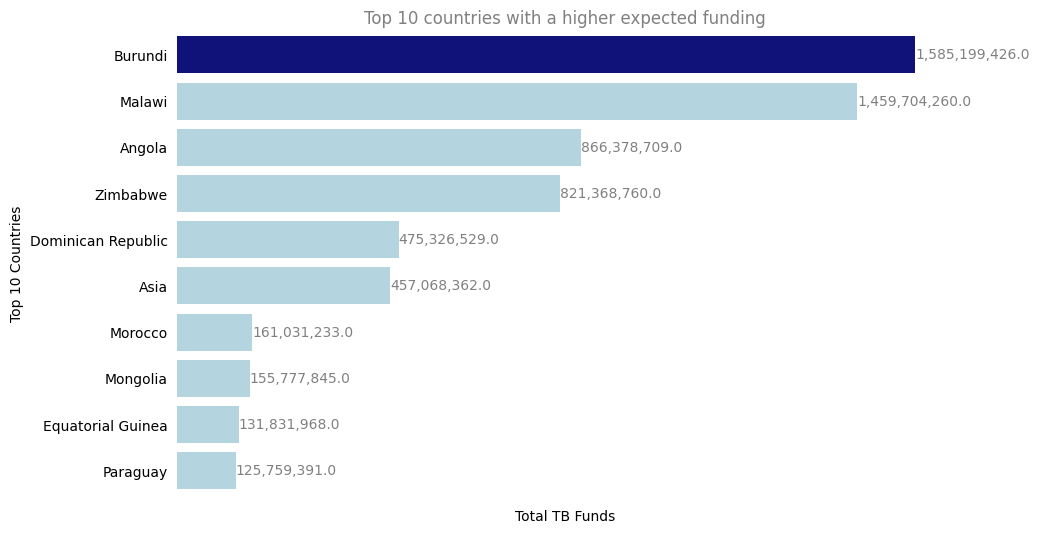

In [17]:
#plot top ten countries with a higher expected funding 
top_10 = tb_funds.nlargest(10, 'total_expected_funding').copy()

# Identify the maximum value
max_value = top_10['total_expected_funding'].max()

# Create a new column for color assignment
top_10['color'] = top_10['total_expected_funding'].apply(lambda x: 'darkblue' if x == max_value else 'lightblue')

plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10, x='total_expected_funding',
                  y='Entity',
                  palette=top_10['color'].to_list())

#add title
plt.title('Top 10 countries with a higher expected funding', color="grey")

# remove x-axis tick labels
ax.xaxis.set_ticklabels([])
# rename axes labels
ax.set(xlabel='Total TB Funds', ylabel='Top 10 Countries')
# Remove tick marks
plt.tick_params(left=False, bottom=False)  # `left` for y-axis and `bottom` for x-axis

# remove border
sns.despine(bottom=True);
plt.gca().spines['left'].set_visible(False)

# Add data labels using ax.patches (each bar is a rectangle in the plot)
for patch in ax.patches:
    # Get the height of each bar (total_expected_funding)
    value = patch.get_width()
    ax.text(patch.get_width()+10, patch.get_y() + patch.get_height() / 2,  # Position text next to the bar
            f'{value:,.1f}', ha='left', va='center', fontsize=10, color="grey")


#### Assessing relationships in mortality and funding of countries 

In [18]:
tb_death_for_merge = tb_death[['Code','est_mortality']] 
tb_funds_for_merge = tb_funds[['Entity','Code','funding_year','total_expected_funding']]
merged_h1 = pd.merge(tb_death_for_merge,tb_funds_for_merge, on='Code',how='right')
print(merged_h1)

    Code  est_mortality       Entity funding_year  total_expected_funding
0    AFG        24.0000  Afghanistan         2022                 7827492
1    AGO        62.0000       Angola         2022               866378709
2    ARG         1.8000    Argentina         2022                 6146960
3    ARM         1.7000      Armenia         2022                 4133663
4    CIV        25.0000         Asia         2022               457068362
..   ...            ...          ...          ...                     ...
96   VEN         3.3000    Venezuela         2022                 2474838
97   VNM        14.0000      Vietnam         2022                24494260
98   YEM         8.4000        Yemen         2022                 3460388
99   ZMB        26.0000       Zambia         2022                13478581
100  ZWE        51.0000     Zimbabwe         2022               821368760

[101 rows x 5 columns]


In [19]:
merged_h1.info()
merged_h1["total_expected_funding"]=merged_h1["total_expected_funding"].astype("int")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code                    101 non-null    object 
 1   est_mortality           100 non-null    float64
 2   Entity                  101 non-null    object 
 3   funding_year            101 non-null    object 
 4   total_expected_funding  101 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 4.1+ KB


In [20]:
#countries with funding and est mortality
# Correlation between Variable1 and Variable2
corr_1 = merged_h1['est_mortality'].corr(merged_h1['total_expected_funding'])
print(f"Correlation: {corr_1}")

Correlation: 0.029616130121853608


###### The correlation implies that there is a weak chance countries with high expected funding to cob tb have low mortality rates. In other words, as healthcare funding increases, there might be a slight tendency for TB death rates to reduce

Y-axis range:  266448.0178269429 2397842427.4464965


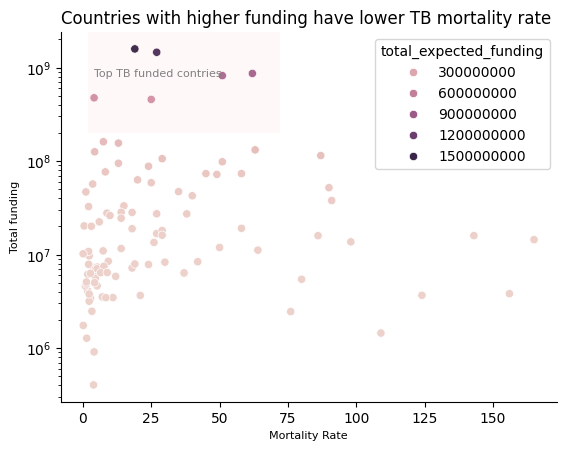

In [ ]:


# Create the scatter plot to visualize the relationship
sns.scatterplot(data=merged_h1, x='est_mortality', y='total_expected_funding', hue='total_expected_funding')

# Adding title and labels
plt.title('Countries with higher funding have lower TB mortality rate ')
plt.xlabel('Mortality Rate', size=8)
plt.ylabel('Total funding', size=8)

# Apply logarithmic scale on the Y-axis
plt.yscale('log',)


# Get the current Y-axis range to position the rectangle
ymin, ymax = plt.ylim()

# Print ymin and ymax to ensure the rectangle fits within this range
print("Y-axis range: ", ymin, ymax)

# Define rectangle parameters (adjust as needed based on data and plot range)
# Here, left and bottom define the starting point of the rectangle, width and height define the size
left, bottom, width, height = (2, 2 * 10**8, 70, 3 * 10**9)  # Example values (you can modify them)

# Create a rectangle object with transparency and color
rect = mpatches.Rectangle((left, bottom), width, height, alpha=0.1, facecolor="pink", linewidth=2)

# Add the rectangle to the plot
plt.gca().add_patch(rect)

# Optionally, add a text annotation inside the rectangle (adjust coordinates as needed)
plt.text(left + 2, bottom + height * 0.2, 'Top TB funded countries', fontsize=8, color='grey')

# Remove borders around the chart
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()


##### More glimpse into relationships 

In [22]:
# Top 5 by 'total_expected_funding'
top_5 = tb_funds.nlargest(5, 'total_expected_funding').copy()
top_5['Category'] = 'Top 5 by funding'

# Bottom 5 by 'total_expected_funding'
bottom_5 = tb_funds.nsmallest(5, 'total_expected_funding').copy()
bottom_5['Category'] = 'Bottom 5 by funding'

# Combine Top 5 and Bottom 5 into a single DataFrame
top_bottom_combined = pd.concat([top_5, bottom_5], ignore_index=True)

# Display the combined DataFrame
top_bottom_combined.head(10)

,Entity,Code,exp_global_fund,funding_year,Budget gap,Expected funding from USAID,Expected funding from other grants,Total expected domestic funding,total_expected_funding,Category
0,Burundi,BDI,1488356.0000,2022,8365327.0000,0.0000,0.0000,1583711070.0000,1585199426,Top 5 by funding
1,Malawi,MWI,5902615.0000,2022,14613982.0000,0.0000,0.0000,1453801645.0000,1459704260,Top 5 by funding
2,Angola,AGO,4213441.0000,2022,18901125.0000,0.0000,11669.0000,862153599.0000,866378709,Top 5 by funding
3,Zimbabwe,ZWE,9487457.0000,2022,7808495.0000,19705791.0000,0.0000,792175512.0000,821368760,Top 5 by funding
4,Dominican Republic,DOM,1071648.0000,2022,851.0000,150000.0000,0.0000,474104881.0000,475326529,Top 5 by funding
5,Mexico,MEX,0.0000,2022,0.0000,0.0000,0.0000,403041.0000,403041,Bottom 5 by funding
6,Suriname,SUR,166202.0000,2022,169763.0000,0.0000,642146.0000,101000.0000,909348,Bottom 5 by funding
7,Bulgaria,BGR,0.0000,2022,0.0000,0.0000,28519.0000,1245367.0000,1273886,Bottom 5 by funding
8,Marshall Islands,MHL,400000.0000,2022,721473.0000,0.0000,385159.0000,661767.0000,1446926,Bottom 5 by funding
9,Syria,SYR,1305100.0000,2022,0.0000,39817.0000,0.0000,399875.0000,1744792,Bottom 5 by funding


In [23]:
#Merged mortality rates with the fund table
#selected a few columns from the mortality dataset to use in analysis
merged_data = pd.merge(top_bottom_combined,tb_death_for_merge, on='Code',how='left')
#did a left join to include all columns from the left table and matching columns from the right table
merged_data = merged_data.sort_values(by='total_expected_funding', ascending=True)
# Sort the merged data by 'total_expected_funding' in descending order

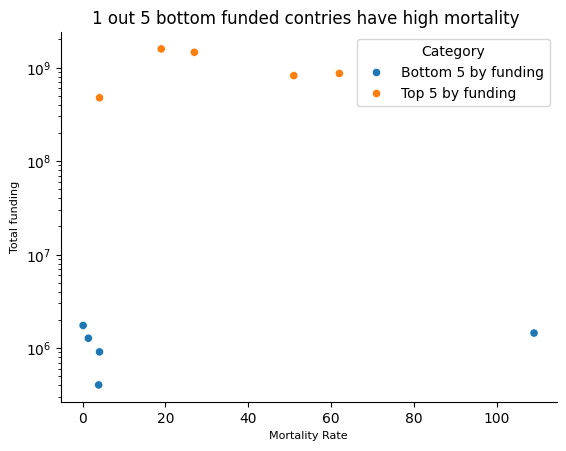

In [ ]:
# Create the scatter plot to visualize the relationship
sns.scatterplot(data=merged_data, x='est_mortality', y='total_expected_funding', hue='Category')
# Adding title and labels
plt.title('1 out 5 bottom funded contries have high mortality ')
plt.xlabel('Mortality Rate', size=8)
plt.ylabel('Total funding', size=8)

# Apply logarithmic scale on the Y-axis
plt.yscale('log',)

# Remove borders around the chart
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

In [25]:
# Create the figure
fig = go.Figure()

# Add mortality rate (left side) as a negative bar for visualization
fig.add_trace(go.Bar(
    x=[-value for value in merged_data['est_mortality']],  # Negate the values
    y=merged_data['Entity'],
    name='mortality',
    orientation='h',
    marker=dict(color='blue'),
    text=merged_data['Category'],  # Display the original positive values in the tooltip
    textposition='outside',
    visible=True
))

# Add expected funding (right side) as a positive bar
fig.add_trace(go.Bar(
    x=merged_data['total_expected_funding'],
    y=merged_data['Entity'],
    name='funding',
    orientation='h',
    marker=dict(color='orange'),
    text=merged_data['Category'],
    textposition='outside',
    visible=True
))

# Update layout
fig.update_layout(
    title='Bi-Directional Bar Chart: Mortality Rate vs. Expected Funding',
    xaxis=dict(title=' ', showgrid=False,showticklabels=False,
      ),
    barmode='relative',  # Bars appear side-by-side
    plot_bgcolor='white',
    margin=dict(l=10, r=50, t=50, b=50),
    legend=dict(title='Metrics', orientation='h', y=-0.2)
)

# Show the chart
fig.show()

In [71]:
def histogram_boxplot(feature, figsize=(8,5), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='white') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="PuBu") if bins else sns.histplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

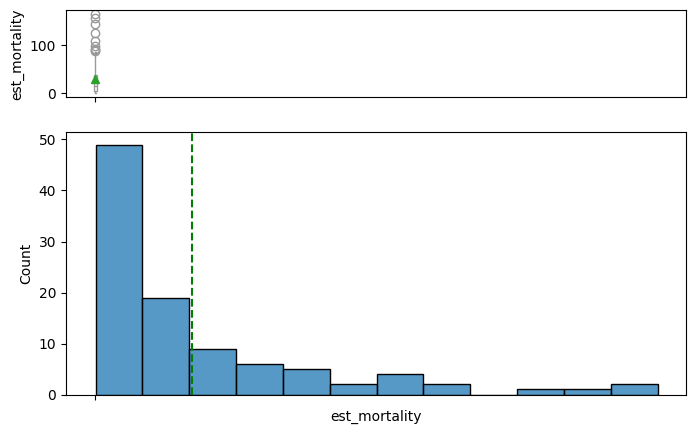

In [72]:
histogram_boxplot(merged_h1['est_mortality'])

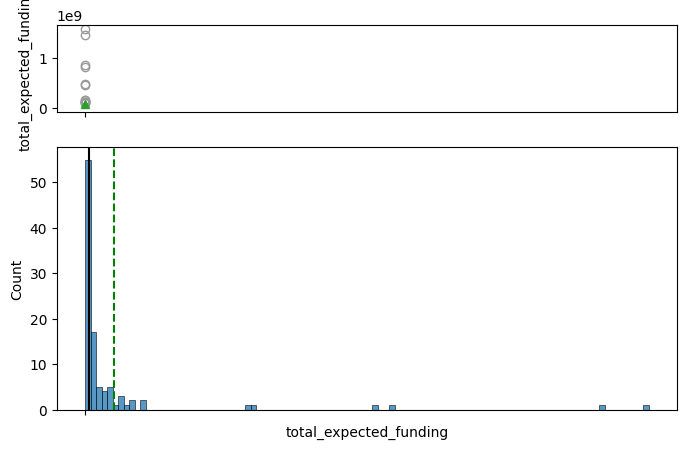

In [73]:
histogram_boxplot(merged_h1['total_expected_funding'])

In [79]:
merged_h1.dropna(subset=['total_expected_funding','est_mortality'], inplace=True)

In [80]:
# Prepare your data
X = merged_h1['est_mortality'].values.reshape(-1, 1)  # Reshaping to make it 2D
y = merged_h1['total_expected_funding']

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Get the coefficients
print(f"Coefficient: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

# Predict values using the model
y_pred = model.predict(X)

# Optionally, you can print predictions or plot the results
print(f"Predictions: {y_pred[:5]}")


Coefficient: 205259.38590188732
Intercept: 76410563.08118185
Predictions: [81336788.34282716 89136645.00709887 76780029.97580525 76759504.03721507
 81542047.72872904]


###### for every 1 unit increase in the est_mortality (estimated mortality), the total_expected_funding (total expected funding) increases by 205,259.39 units
###### if est_mortality were zero, the total expected funding would be 76,410,563.08 units. 

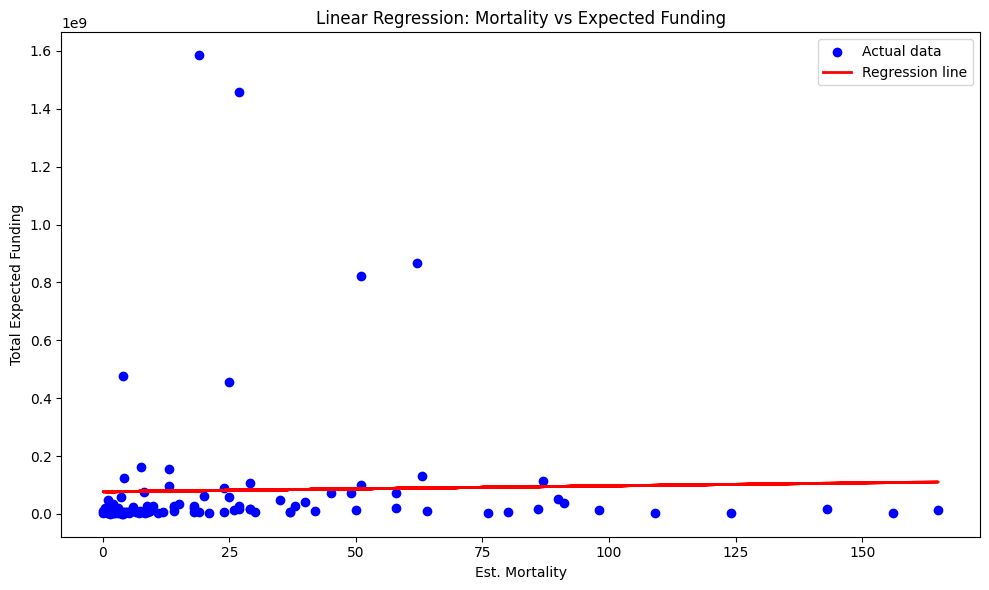

In [82]:
# Plotting the data and the regression line
plt.figure(figsize=(10, 6))

# Scatter plot of actual data points
plt.scatter(X, y, color='blue', label='Actual data')

# Plot the regression line
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression line')

# Adding labels and title
plt.xlabel('Est. Mortality')
plt.ylabel('Total Expected Funding')
plt.title('Linear Regression: Mortality vs Expected Funding')

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Countries with less mortality have lesser incedence rates

In [26]:
merged_h2 = pd.merge(tb_death,tb_incedence, on='Entity',how='left')
merged_h2.drop(columns=['Year_y'], inplace=True)
merged_h2= merged_h2.rename({'Year_x': 'Year'}, axis='columns')
print(merged_h2)

          Entity Code  Year  est_mortality  est_incidence
0    Afghanistan  AFG  2022        24.0000       185.0000
1        Albania  ALB  2022         0.3600        15.0000
2        Algeria  DZA  2022         5.1000        51.0000
3        Andorra  AND  2022         0.4700         5.8000
4         Angola  AGO  2022        62.0000       333.0000
..           ...  ...   ...            ...            ...
190    Venezuela  VEN  2022         3.3000        46.0000
191      Vietnam  VNM  2022        14.0000       176.0000
192        Yemen  YEM  2022         8.4000        48.0000
193       Zambia  ZMB  2022        26.0000       295.0000
194     Zimbabwe  ZWE  2022        51.0000       204.0000

[195 rows x 5 columns]


In [27]:
#countries with funding and est mortality
# Correlation between Variable1 and Variable2
corr_2 = merged_h2['est_mortality'].corr(merged_h2['est_incidence'])
print(f"Correlation: {corr_2}")

Correlation: 0.8651395234498419


Y-axis range:  -8.25 173.25


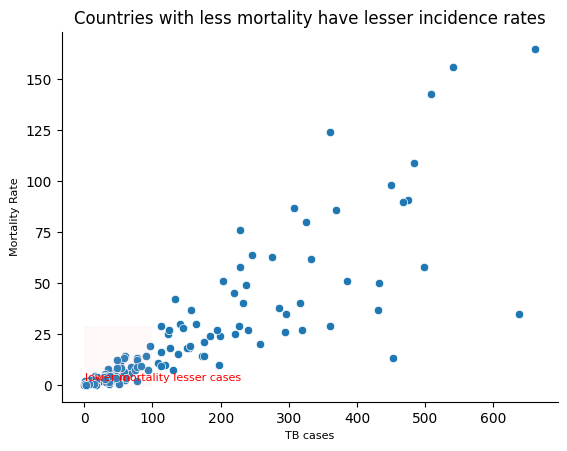

In [91]:
# Create the scatter plot to visualize the relationship
sns.scatterplot(data=merged_h2, x='est_incidence', y='est_mortality')
# Adding title and labels
plt.title('Countries with less mortality have lesser incidence rates')
plt.xlabel('TB cases', size=8)
plt.ylabel('Mortality Rate', size=8)

# Get the current Y-axis range to position the rectangle
ymin, ymax = plt.ylim()

# Print ymin and ymax to ensure the rectangle fits within this range
print("Y-axis range: ", ymin, ymax)

# Define rectangle parameters (adjust as needed based on data and plot range)
# Here, left and bottom define the starting point of the rectangle, width and height define the size
left, bottom, width, height = (-1, -1, 100, 30)  # Example values (you can modify them)

# Create a rectangle object with transparency and color
rect = mpatches.Rectangle((left, bottom), width, height, alpha=0.1, facecolor="pink", linewidth=2)

# Add the rectangle to the plot
plt.gca().add_patch(rect)

# Optionally, add a text annotation inside the rectangle (adjust coordinates as needed)
plt.text(left + 2, bottom + height * 0.1, 'lower mortality lesser cases', fontsize=8, color='red')

# Remove borders around the chart
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

In [32]:
# Top 5 by 'total_expected_funding'
top_5_1 = merged_h2.nlargest(5, 'est_mortality').copy()
top_5_1['Category'] = 'Top 5 by funding'

# Bottom 5 by 'total_expected_funding'
bottom_5_1 = merged_h2.nsmallest(5, 'est_mortality').copy()
bottom_5_1['Category'] = 'Bottom 5 by funding'

# Combine Top 5 and Bottom 5 into a single DataFrame
top_bottom_combined_1= pd.concat([top_5_1, bottom_5_1], ignore_index=True)

# Display the combined DataFrame
top_bottom_combined_1.head(10)

,Entity,Code,Year,est_mortality,est_incidence,Category
0,Lesotho,LSO,2022,165.0000,661.0000,Top 5 by funding
1,Central African Republic,CAF,2022,156.0000,540.0000,Top 5 by funding
2,Gabon,GAB,2022,143.0000,509.0000,Top 5 by funding
3,Guinea-Bissau,GNB,2022,124.0000,361.0000,Top 5 by funding
4,Marshall Islands,MHL,2022,109.0000,483.0000,Top 5 by funding
5,San Marino,SMR,2022,0.0000,0.0000,Bottom 5 by funding
6,Palestine,PSE,2022,0.0500,0.5000,Bottom 5 by funding
7,Jordan,JOR,2022,0.0900,3.8000,Bottom 5 by funding
8,Monaco,MCO,2022,0.0900,1.1000,Bottom 5 by funding
9,Syria,SYR,2022,0.1400,17.0000,Bottom 5 by funding


c:\Users\debor\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.

c:\Users\debor\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning:

Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.



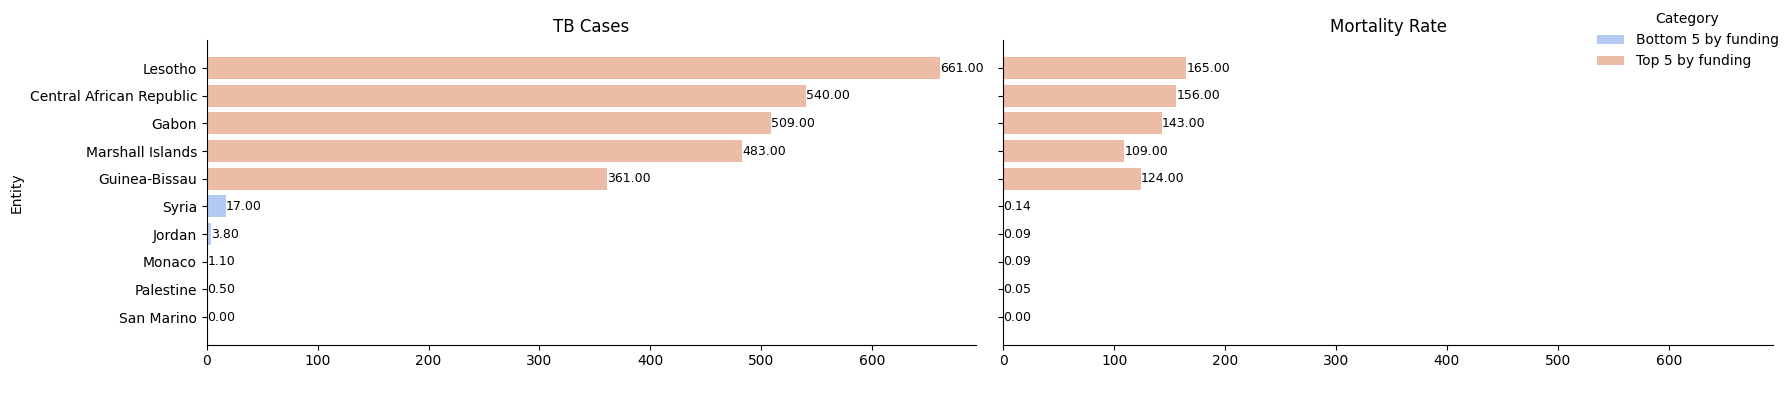

In [58]:
# Define a melted DataFrame for PairGrid
melted_data = pd.melt(
    top_bottom_combined_1,
    id_vars=['Entity','Category'],
    value_vars=['est_incidence', 'est_mortality'],
    var_name='Metric',
    value_name='Value'
)

# Sort by 'Value' in descending order for each 'Metric'
melted_data = melted_data.sort_values([ 'Value'], ascending=[ True])

# Create a PairGrid
g = sns.FacetGrid(
    data=melted_data,
    col='Metric',
    aspect=2,  # Adjust width
    height=4   # Adjust height
)

# Map barplot to each row
g.map(sns.barplot, 'Value', 'Entity','Category',palette="coolwarm")

# Add data labels to each bar
for ax in g.axes.flat:  # Loop through all axes in the grid
    for container in ax.containers:  # Access the bar containers
        # Add bar labels
        ax.bar_label(
            container,
            fmt='%.2f',  # Format as integers
            label_type='edge',  # Place labels at the edge of bars
            fontsize=9,
            color='black'
        )

# Add a legend for the 'Category' variable
g.add_legend(title="Category", loc='upper right')

# Customize titles and labels

titles = ['TB Cases', 'Mortality Rate']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# Adjust layout to fit new titles
plt.tight_layout()

g.set_axis_labels(" ", "Entity")  # Set common axis labels
g.set(ylim=(-1, len(melted_data['Entity'].unique())))  # Adjust y-axis limits

# Improve layout to avoid overlaps
plt.tight_layout()
plt.show()

add maps